In [27]:
import json

data = [
    {
        'channel': 1,
        'weight': 0.00,
        'outdir': 'test',
    },
    {
        'channel': 1,
        'weight': 0.05,
        'outdir': 'test',
    },
    {
        'channel': 2,
        'weight': 0.00,
        'outdir': 'test',
    },
    {
        'channel': 2,
        'weight': 0.05,
        'outdir': 'test',
    },

]
with open('conditions.json', 'w') as f:
    json.dump(data, f, indent=2)

In [2]:
import pickle

from scipy.stats import multivariate_normal
from scipy.signal import fftconvolve
from skimage import restoration
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision import datasets

from train_agent import blur

In [11]:
def moving_average(r, n=100, label=''):
    print(n)
    ret = np.cumsum(r)
    ret[n:] = ret[n:] - ret[:-n]
    moving_average = ret[n - 1:] / n
    return moving_average

In [4]:
def show_rewards(dir_path, n=1000, label='', head=None):
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Reward')
    plt.ylim(-0.25, -0.1)
    with open('%s/reward.pkl' % dir_path, 'rb') as f2:
        reward = pickle.load(f2)
    ma = moving_average(reward, n=n, label=label)
    plt.plot(ma, label=label)
#     plt.legend(bbox_to_anchor=(-0.5, 0), loc='lower left')

In [1]:
# define Q function
device = 'cuda:0'
class MnistNet(torch.nn.Module):
    def __init__(self, c=1, m=[20, 20, 5]):
        super(MnistNet, self).__init__()
        self.m = m
        self.conv1 = torch.nn.Conv2d(c, self.m[0], 5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(self.m[0], self.m[1], 5, stride=1, padding=0)
        self.fc = torch.nn.Linear(4*4*self.m[1], m[2])
        self.scale = torch.nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*self.m[1])
        x = self.fc(x)
        return x, self.scale*x 

Qnet = MnistNet(m=[20, 20, len(filt)])
Qnet.load_state_dict(torch.load('channel01_weight000_seed00/Qnet020000.pth'))

NameError: name 'torch' is not defined

### 復元処理候補からぼやけさせる処理を省いたらどうなる

In [20]:
target_model_dir = 'withRandom/channel01_weight000_seed00'

1000


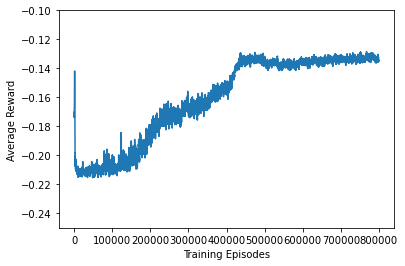

In [21]:
show_rewards(target_model_dir, label='average reward')

### ↑のagentを用いた復元

In [6]:
filt = []
filt.append(lambda x: x)
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel1, 1e-2)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel2, 1e-2)))

def restore_by_agent(Qnet, blur_img):
    restore = torch.from_numpy(blur_img).to(torch.float)
    for _ in range(5):
        with torch.no_grad():
            q, _ = Qnet(restore[None, None, ...])
            q = q[0].numpy()
            a = np.argmax(q)
        restore = filt[a](restore.numpy())
        restore = torch.from_numpy(restore).to(torch.float)
    return restore.numpy()


def measure_agent_ability(target_dir):
    Qnet = MnistNet(m=[20, 20, len(filt)])
    Qnet.load_state_dict(torch.load('%s/Qnet040000.pth' % target_dir))
    data = datasets.MNIST(root='./data', train=False)
    test_imgs = data.data.numpy() / 255
    N = 10000

    samples = []
    for test_img in tqdm(test_imgs[:N]):
        results_per_img = []
        # filt 3 times
        img_blurred_by_gauss = blur(test_img, gauss_filt, 3)
        restore1 = restore_by_agent(Qnet, img_blurred_by_gauss)
        results_per_img.append(np.mean((restore1-test_img)**2))

        img_blurred_by_random = blur(test_img, random_filt, 3)
        restore2 = restore_by_agent(Qnet, img_blurred_by_random)
        results_per_img.append(np.mean((restore2-test_img)**2))

        img_blurred_by_smooth = blur(test_img, smooth_filt, 3)
        restore3 = restore_by_agent(Qnet, img_blurred_by_smooth)
        results_per_img.append(np.mean((restore3-test_img)**2))
        samples.append(results_per_img)
    return np.array(samples)

In [144]:
samples000 = measure_agent_ability('withRandom/channel01_weight000_seed00')
samples000.mean(axis=0)

array([0.02812058, 0.03015124, 0.03165078])

In [147]:
samples005 = measure_agent_ability('withRandom/channel01_weight005_seed00')
samples005.mean(axis=0)

array([0.01733715, 0.02158289, 0.02506648])

### その復元画像

### ３つのフィルタそれぞれでぼやかした画像は最初の時点でどの程度違う？

In [74]:
filt = []
filt.append(lambda x: x)
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel1, mode='same')))
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel2, mode='same')))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel1, 1e-2)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel2, 1e-2)))

In [66]:
N = 10000
data = datasets.MNIST(root='./data', train=False, download=True)
samples1 = []
for idx in tqdm(range(N)):
    test_img = data.data[idx].numpy() / 255
    result_per_times = []
    for i in range(1, 6):
        img_blurred_by_gauss = blur(test_img, gauss_filt, i)
        img_blurred_by_random = blur(test_img, random_filt, i)
        img_blurred_by_smooth = blur(test_img, smooth_filt, i)
        
        diff_g_vs_r = np.mean((img_blurred_by_gauss - img_blurred_by_random)**2)
        diff_g_vs_s = np.mean((img_blurred_by_gauss - img_blurred_by_smooth)**2)
        diff_r_vs_s = np.mean((img_blurred_by_random - img_blurred_by_smooth)**2)
        
        result_per_times.append([diff_g_vs_r, diff_g_vs_s, diff_r_vs_s])
    samples1.append(result_per_times)
samples1 = np.array(samples1)

In [48]:
for label, row in zip(['gauss vs random', 'gauss vs smooth', 'random vs smooth'], samples1.mean(axis=0).T):
    print(label, end=' ')
    for cell in row:
        print(round(cell, 4), end='\t')
    print()

gauss vs random 0.0006	0.0003	0.0003	0.0002	0.0002	
gauss vs smooth 0.0007	0.0004	0.0003	0.0003	0.0003	
random vs smooth 0.0002	0.0001	0.0001	0.0001	0.0001	


### ランダムフィルタでぼやけさせた画像にガウスフィルタでぼやけた画像に対して決定する行動系列を用いたらどうなる?

In [63]:
N = 10000
test_imgs = data.data.numpy() / 255
samples2 = []
for test_img in tqdm(test_imgs):
    img_blurred_by_gauss = blur(test_img, gauss_filt, 3)
    img_blurred_by_random = blur(test_img, random_filt, 3)
    
    # get determined actions from agent for img blurred by gauss filt
    actions = []
    restore = torch.from_numpy(img_blurred_by_gauss).to(torch.float)
    for _ in range(5):
        with torch.no_grad():
            q, _ = Qnet(restore[None, None, ...])
            q = q[0].numpy()
            a = np.argmax(q)
            actions.append(a)
        restore = torch.from_numpy(filt[a](restore.numpy())).to(torch.float)
    # use only gauss wiener to restore image
    restore2 = img_blurred_by_random
    for a in actions:
        restore2 = filt[a](restore2)
    samples2.append(np.mean((restore2-test_img)**2))
samples2 = np.array(samples2)

In [64]:
samples2.mean(axis=0)

0.024949035390108783